## Preprocessing the Data

In [183]:
!pip install plotly
!pip install dmba
!pip install shap

In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
# Import required libraries
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model as sklm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, \
    GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, \
    precision_score, r2_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dmba import regressionSummary, exhaustive_search,backward_elimination
import shap
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus as pplus
from matplotlib.ticker import MaxNLocator

In [186]:

#sdg = pd.read_csv('/content/drive/MyDrive/All Dataset for Python/Final Project/cleaned_SDGTransformed_New_Long_Format_Data.csv')
sdg = pd.read_csv('/content/drive/MyDrive/SDG_DataSet.csv')

In [187]:
pivot_df = sdg.pivot_table(
    index=['Country Name', 'Country Code', 'Year'],
    columns='Series Name',
    values='Value'
).reset_index()

# Define a threshold to retain columns with sufficient non-NaN values:
# - Calculate 75% of the total number of rows.
threshold = len(pivot_df) * 0.75

# Drop columns where the number of non-NaN values is below the threshold.
pivot_df = pivot_df.dropna(axis=1, thresh=threshold)

# Create a copy of the cleaned DataFrame for visualization purposes.
visual_df = pivot_df.copy()


pivot_df = pivot_df.drop(columns=['Country Name', 'Year', 'Country Code']).reset_index(drop=True)
pivot_df = pivot_df.fillna(pivot_df.median())

## Linear Regression Models

In [188]:
# Define the predictors (independent variables) by excluding the target column
# 'Suicide mortality rate (per 100,000 population)' from the DataFrame.
predictors = pivot_df.drop(columns=["Suicide mortality rate (per 100,000 population)"]).columns
outcome = "Suicide mortality rate (per 100,000 population)"

X = pivot_df[predictors]
Y = pivot_df[outcome]

# Add a constant column to the feature matrix (X) for the intercept term in the regression model.
X=sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
# Display the summary of the regression results, which includes statistics such as R-squared, coefficients, and p-values
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Suicide mortality rate (per 100,000 population)   R-squared:                       1.000
Model:                                                         OLS   Adj. R-squared:                  1.000
Method:                                              Least Squares   F-statistic:                     7512.
Date:                                             Tue, 03 Dec 2024   Prob (F-statistic):           5.41e-81
Time:                                                     01:24:03   Log-Likelihood:                 213.74
No. Observations:                                              105   AIC:                            -313.5
Df Residuals:                                                   48   BIC:                            -162.2
Df Model:                                                       56                                         
Covariance Type:                                         nonrobust                                         
================================================================================================================================================================
                                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                           -0.0041      0.002     -2.571      0.013      -0.007      -0.001
Access to clean fuels and technologies for cooking (% of population)                            -0.0149      0.008     -1.818      0.075      -0.031       0.002
Access to electricity (% of population)                                                         -0.0005      0.005     -0.104      0.917      -0.010       0.009
Access to electricity, rural (% of rural population)                                             0.0008      0.006      0.131      0.896      -0.012       0.014
Access to electricity, urban (% of urban population)                                             0.0164      0.017      0.985      0.329      -0.017       0.050
Adjusted net savings, excluding particulate emission damage (% of GNI)                          -0.0707      0.017     -4.122      0.000      -0.105      -0.036
Adolescent fertility rate (births per 1,000 women ages 15-19)                                   -0.0416      0.020     -2.060      0.045      -0.082      -0.001
Agriculture value added per worker (constant 2010 US$)                                        1.903e-06   1.65e-06      1.154      0.254   -1.41e-06    5.22e-06
Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)                1.488e-05   4.62e-06      3.221      0.002    5.59e-06    2.42e-05
Air transport, freight (million ton-km)                                                      -5.257e-05   1.73e-05     -3.039      0.004   -8.74e-05   -1.78e-05
Air transport, passengers carried                                                             1.383e-09   7.65e-10      1.806      0.077   -1.56e-10    2.92e-09
Aquaculture production (metric tons)                                                          6.871e-07   2.14e-07      3.216      0.002    2.58e-07    1.12e-06
Broad money growth (annual %)                                                                    0.0031      0.005      0.630      0.532      -0.007       0.013
Broad money to total reserves ratio                                                             -0.0330      0.006     -5.553      0.000      -0.045      -0.021
CO2 emissions (kg per 2015 

### Backward Elimination to find the best variables

In [189]:
#Finding best variables using backward elimination approach
def train_model(variables):
    model = sklm.LinearRegression()
    model.fit(X[variables], Y)
    return model

def score_model(model, variables):
    return AIC_score(Y, model.predict(X[variables]), model)

best_model, best_variables = backward_elimination(X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: const, Access to clean fuels and technologies for cooking (% of population), Access to electricity (% of population), Access to electricity, rural (% of rural population), Access to electricity, urban (% of urban population), Adjusted net savings, excluding particulate emission damage (% of GNI), Adolescent fertility rate (births per 1,000 women ages 15-19), Agriculture value added per worker (constant 2010 US$), Agriculture, forestry, and fishing, value added per worker (constant 2015 US$), Air transport, freight (million ton-km), Air transport, passengers carried, Aquaculture production (metric tons), Broad money growth (annual %), Broad money to total reserves ratio, CO2 emissions (kg per 2015 US$ of GDP), CO2 emissions (kg per 2017 PPP $ of GDP), CO2 emissions (kg per PPP $ of GDP), CO2 emissions (metric tons per capita), Capture fisheries production (metric tons), Cereal yield (kg per hectare), Coal rents (% of GDP), Compulsory education, duration (years), Contributing 

In [190]:
len(best_variables)

126

### Linear Regression Model with best variables

In [191]:
#Creating Linear regression model using best variables
X1 = pivot_df[best_variables]
Y = pivot_df[outcome]

X1=sm.add_constant(X1)
model = sm.OLS(Y, X1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Suicide mortality rate (per 100,000 population)   R-squared:                       1.000
Model:                                                         OLS   Adj. R-squared:                  1.000
Method:                                              Least Squares   F-statistic:                     8456.
Date:                                             Tue, 03 Dec 2024   Prob (F-statistic):           3.16e-82
Time:                                                     01:26:35   Log-Likelihood:                 219.96
No. Observations:                                              105   AIC:                            -325.9
Df Residuals:                                                   48   BIC:                            -174.6
Df Model:                                                       56                                         
Covariance Type:                                         nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                      0.0016      0.001      1.084      0.284      -0.001       0.005
Access to electricity (% of population)                                                   -0.0092      0.009     -1.057      0.296      -0.027       0.008
Access to electricity, rural (% of rural population)                                       0.0016      0.010      0.156      0.877      -0.019       0.022
Adjusted net savings, excluding particulate emission damage (% of GNI)                    -0.0582      0.020     -2.913      0.005      -0.098      -0.018
Adolescent fertility rate (births per 1,000 women ages 15-19)                             -0.0330      0.024     -1.401      0.168      -0.080       0.014
Agriculture value added per worker (constant 2010 US$)                                  2.751e-06   1.58e-06      1.739      0.088    -4.3e-07    5.93e-06
Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)         -1.973e-06   4.03e-06     -0.490      0.627   -1.01e-05    6.13e-06
Air transport, freight (million ton-km)                                                -3.899e-06   1.52e-05     -0.257      0.798   -3.44e-05    2.66e-05
Air transport, passengers carried                                                       1.724e-09   7.23e-10      2.383      0.021    2.69e-10    3.18e-09
Aquaculture production (metric tons)                                                   -2.751e-07   3.07e-07     -0.896      0.375   -8.92e-07    3.42e-07
Broad money growth (annual %)                                                              0.0010      0.005      0.200      0.842      -0.009       0.011
Broad money to total reserves ratio                                                       -0.0003      0.005     -0.057      0.955      -0.010       0.009
CO2 emissions (kg per 2017 PPP $ of GDP)                                                   0.0044      0.001      4.812      0.000       0.003       0.006
CO2 emissions (metric tons per capita)                                                    -0.0705      0.021     -3.283      0.002      -0.114      -0.027
Capture fisheries production (metric tons)                                             -1.608e-07   3.95e-07     -0.407      0.68

### Handling Multicollinearity

In [192]:
#Calculating VIF for all independent variables and removing variables whose VIF is higher than 4
X1 = pivot_df[best_variables]

vif_data = pd.DataFrame()
vif_data["feature"] = X1.columns
vif_data['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif_data = vif_data.sort_values(by='VIF', ascending=False)

while vif_data['VIF'].iloc[0] > 4:
    X1 = X1.drop(vif_data['feature'].iloc[0], axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X1.columns
    vif_data['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
    vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data.reset_index(drop=True, inplace=True)

vif_data

,feature,VIF
0,GNI per capita growth (annual %),3.026050
1,tax revenue (current LCU),2.893760
2,"Foreign direct investment, net inflows (BoP, c...",2.865210
3,"Tariff rate, applied, weighted mean, all produ...",2.852240
4,Coal rents (% of GDP),2.639392
5,"Compulsory education, duration (years)",2.568197
6,"Unemployment, total (% of total labor force) (...",2.519504
7,Broad money growth (annual %),2.490281
8,"Patent applications, residents",2.387644
9,Proportion of seats held by women in national ...,2.344433


In [193]:
#Creating Linear regression post removing multicollinearity
X2=pivot_df[vif_data['feature'].values]
X2=sm.add_constant(X2)
model = sm.OLS(Y, X2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Suicide mortality rate (per 100,000 population)   R-squared:                       0.851
Model:                                                         OLS   Adj. R-squared:                  0.814
Method:                                              Least Squares   F-statistic:                     22.60
Date:                                             Tue, 03 Dec 2024   Prob (F-statistic):           6.64e-26
Time:                                                     01:27:39   Log-Likelihood:                -162.87
No. Observations:                                              105   AIC:                             369.7
Df Residuals:                                                   83   BIC:                             428.1
Df Model:                                                       21                                         
Covariance Type:                                         nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                            0.3138      2.887      0.109      0.914      -5.429       6.056
GNI per capita growth (annual %)                                                 0.0235      0.044      0.534      0.595      -0.064       0.111
tax revenue (current LCU)                                                     1.391e-13   4.24e-14      3.277      0.002    5.47e-14    2.23e-13
Foreign direct investment, net inflows (BoP, current US$)                     1.072e-11      2e-12      5.360      0.000    6.74e-12    1.47e-11
Tariff rate, applied, weighted mean, all products (%)                            0.2605      0.043      6.092      0.000       0.175       0.345
Coal rents (% of GDP)                                                            0.0564      0.243      0.232      0.817      -0.427       0.540
Compulsory education, duration (years)                                          -0.0840      0.110     -0.766      0.446      -0.302       0.134
Unemployment, total (% of total labor force) (modeled ILO estimate)              0.1537      0.121      1.273      0.207      -0.086       0.394
Broad money growth (annual %)                                                    0.0886      0.030      2.920      0.005       0.028       0.149
Patent applications, residents                                               -2.933e-06   6.63e-07     -4.423      0.000   -4.25e-06   -1.61e-06
Proportion of seats held by women in national parliaments (%)                   -0.0091      0.023     -0.400      0.690      -0.055       0.036
Foreign direct investment, net inflows (% of GDP)                               -0.2657      0.091     -2.926      0.004      -0.446      -0.085
Inflation, consumer prices (annual %)                                            0.0466      0.074      0.626      0.533      -0.101       0.195
Tariff rate, applied, weighted mean, primary products (%)                       -0.0013      0.020     -0.065      0.949      -0.041       0.038
Tax revenue (% of GDP)                                                          -0.1404      0.025     -5.521      0.000      -0.191      -0.090
Immunization, HepB3 (% of one-year-old children)                                -0.0556      0.009     -6.133      0.000      -0.074      -0.038
Household

### Checking for Non-Normality

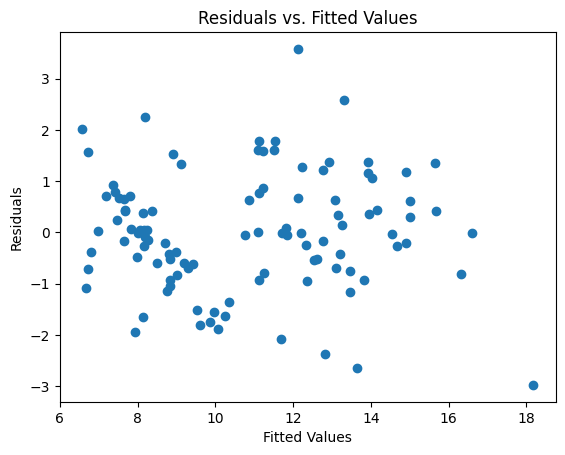

Breusch-Pagan test p-value: 0.5318654520312872


In [194]:
# Plot of Residuals vs Fitted values
residuals=results.resid
plt.scatter(results.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# Breusch-Pagan test for Heteroscedasticity
_, p_value, _, _ = sms.het_breuschpagan(residuals, model.exog)
print(f"Breusch-Pagan test p-value: {p_value}")

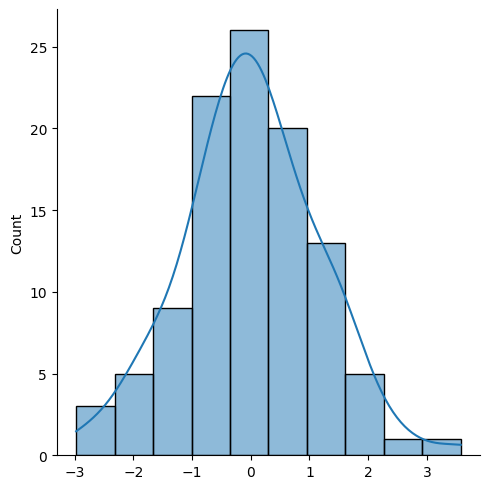

In [195]:
# Checking for normality of model
sns.displot(residuals, bins=10, kde=True, kind="hist")

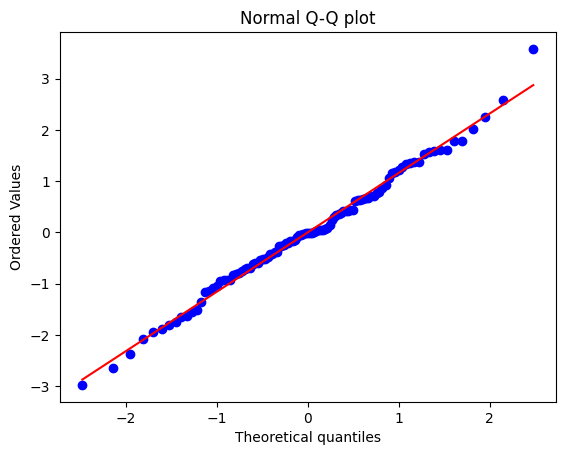

Shapiro-Wilk test p-value: 0.9078371893083488


In [196]:
# Check for Normality of Residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

# Shapiro-Wilk test for normality
_, p_value_shapiro = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value_shapiro}")

### Dropping the variables which have a higher p-value & not significant with respect to model

In [197]:
#These variables had high p-values and did not play a major role in the adjsuted r-square value
#When these variables are removed, there is no effect seen in Adj R-Sq
variables_to_drop = [
    'Coal rents (% of GDP)',
    'Compulsory education, duration (years)',
    'Proportion of seats held by women in national parliaments (%)',
    'GNI per capita growth (annual %)',
    'Tariff rate, applied, weighted mean, primary products (%)',
    'Exports of goods and services (annual % growth)',
    'Inflation, consumer prices (annual %)'
    ]
X3=pivot_df[vif_data['feature'].values].drop(columns=variables_to_drop)
X3=sm.add_constant(X3)
model3 = sm.OLS(Y, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Suicide mortality rate (per 100,000 population)   R-squared:                       0.847
Model:                                                         OLS   Adj. R-squared:                  0.823
Method:                                              Least Squares   F-statistic:                     35.49
Date:                                             Tue, 03 Dec 2024   Prob (F-statistic):           1.54e-30
Time:                                                     01:27:40   Log-Likelihood:                -164.44
No. Observations:                                              105   AIC:                             358.9
Df Residuals:                                                   90   BIC:                             398.7
Df Model:                                                       14                                         
Covariance Type:                                         nonrobust                                         
================================================================================================================================================
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                           -0.3685      2.442     -0.151      0.880      -5.221       4.484
tax revenue (current LCU)                                                     1.705e-13   3.53e-14      4.829      0.000       1e-13    2.41e-13
Foreign direct investment, net inflows (BoP, current US$)                     1.078e-11   1.77e-12      6.077      0.000    7.25e-12    1.43e-11
Tariff rate, applied, weighted mean, all products (%)                            0.2506      0.030      8.269      0.000       0.190       0.311
Unemployment, total (% of total labor force) (modeled ILO estimate)              0.1766      0.104      1.704      0.092      -0.029       0.382
Broad money growth (annual %)                                                    0.1023      0.025      4.111      0.000       0.053       0.152
Patent applications, residents                                               -3.058e-06    5.7e-07     -5.361      0.000   -4.19e-06   -1.92e-06
Foreign direct investment, net inflows (% of GDP)                               -0.2948      0.081     -3.643      0.000      -0.456      -0.134
Tax revenue (% of GDP)                                                          -0.1377      0.024     -5.728      0.000      -0.186      -0.090
Immunization, HepB3 (% of one-year-old children)                                -0.0553      0.008     -7.071      0.000      -0.071      -0.040
Households and NPISHs Final consumption expenditure (annual % growth)           -0.0443      0.021     -2.103      0.038      -0.086      -0.002
Medium and high-tech manufacturing value added (% manufacturing value added)     0.3391      0.060      5.638      0.000       0.220       0.459
Portfolio investment, net (BoP, current US$)                                  2.279e-12   8.24e-13      2.764      0.007    6.41e-13    3.92e-12
Gross capital formation (annual % growth)                                       -0.0215      0.016     -1.306      0.195      -0.054       0.011
General government final consumption expenditure (annual % growth)              -0.0442      0.025     -1.764      0.081      -0.094       0.006
==============================================================================
Omnibus:                        0.759   Durbin-Watson:                   1.

### Rechecking the VIF Values for remaining variables to ensure if Multicollinearity exists

In [198]:
#Re-verifying
X3 = pivot_df[vif_data['feature'].values].drop(columns=variables_to_drop)

vif_data_1 = pd.DataFrame()
vif_data_1["feature"] = X3.columns
vif_data_1['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif_data_1 = vif_data_1.sort_values(by='VIF', ascending=False)

while vif_data_1['VIF'].iloc[0] > 4:
    X3 = X3.drop(vif_data_1['feature'].iloc[0], axis=1)
    vif_data_1 = pd.DataFrame()
    vif_data_1["feature"] = X3.columns
    vif_data_1['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
    vif_data_1 = vif_data_1.sort_values(by='VIF', ascending=False)
vif_data_1.reset_index(drop=True, inplace=True)

vif_data_1

,feature,VIF
0,"Foreign direct investment, net inflows (BoP, c...",2.416390
1,tax revenue (current LCU),2.107587
2,"Unemployment, total (% of total labor force) (...",1.964814
3,"Patent applications, residents",1.914377
4,"Foreign direct investment, net inflows (% of GDP)",1.782974
5,Broad money growth (annual %),1.681644
6,Tax revenue (% of GDP),1.665654
7,"Immunization, HepB3 (% of one-year-old children)",1.612656
8,"Portfolio investment, net (BoP, current US$)",1.599613
9,Gross capital formation (annual % growth),1.479039


## Validation using Ensemble Methods

### Decision Tree

In [199]:
#This function helps with drawing decision trees using the pydotplus and graphviz libraries
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names

    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features,\
                    class_names=classn, filled=filled)
    graph = pplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [200]:
Y_category = pd.cut(pivot_df[outcome], bins=[0, 10, 20, 30], labels=['Low', 'Medium', 'High'])
#Splitting data as 70% training and 30% testing
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y_category, test_size=0.30, random_state=23)

In [201]:
#Calculating the depth of optimal decision tree having highest accuracy
max_depth_accuracy = {}
DTPrediction_optimal = 0
for depth in range(2, 12):
    DTMortalityReg_optimal = DecisionTreeClassifier(max_depth=depth, max_leaf_nodes=None, \
                                          max_features=None, random_state=23)
    DTMortalityReg_optimal.fit(X_train, Y_train)
    DTPrediction_optimal = DTMortalityReg_optimal.predict(X_test)
    accuracy = accuracy_score(Y_test, DTPrediction_optimal)
    max_depth_accuracy[depth] = accuracy
    print(f"Accuracy for depth {depth}: {accuracy}")

optimal_depth = max(max_depth_accuracy, key=max_depth_accuracy.get)
print(f"Optimal depth: {optimal_depth}")

Accuracy for depth 2: 0.75
Accuracy for depth 3: 0.78125
Accuracy for depth 4: 0.78125
Accuracy for depth 5: 0.8125
Accuracy for depth 6: 0.8125
Accuracy for depth 7: 0.8125
Accuracy for depth 8: 0.8125
Accuracy for depth 9: 0.8125
Accuracy for depth 10: 0.8125
Accuracy for depth 11: 0.8125
Optimal depth: 5


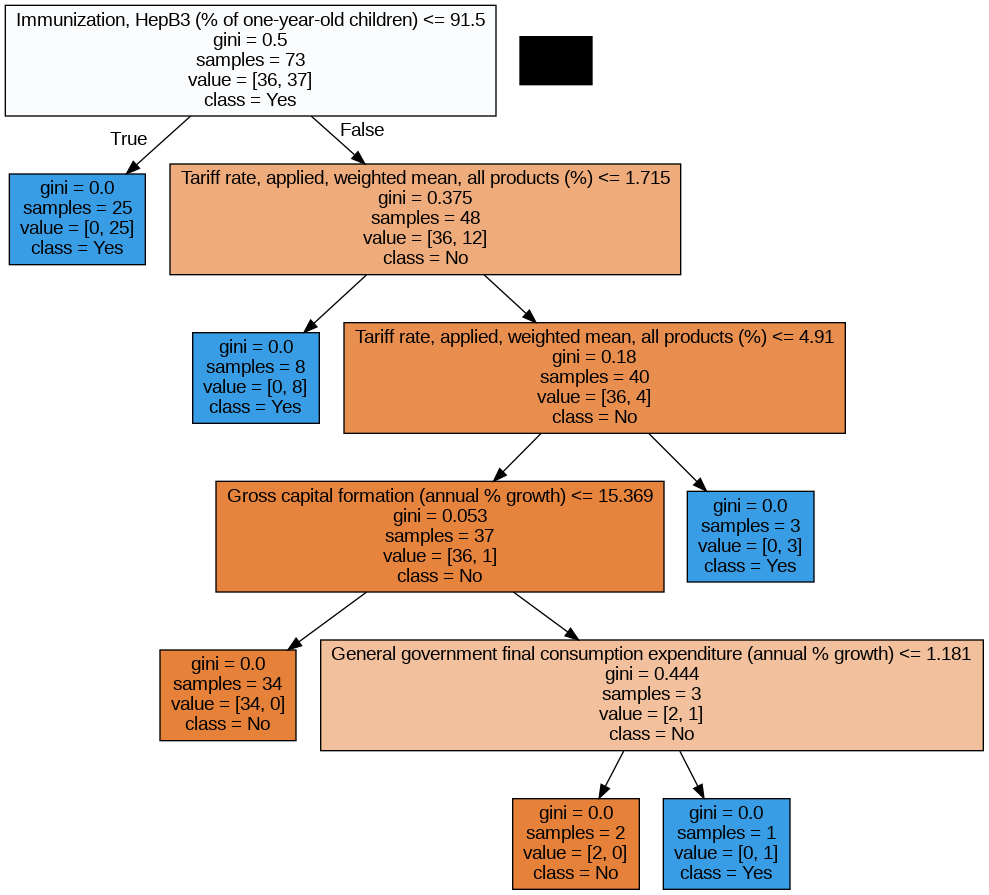

In [202]:
#Decision tree with optimal depth
DT_Credit = DecisionTreeClassifier(max_depth=optimal_depth, max_leaf_nodes=None, \
                                      max_features=None, random_state=23)
DT_Credit.fit(X_train, Y_train)
features = X3.columns
DTCgraph = print_tree(DT_Credit, features=features, class_names=['No', 'Yes']) # 0: 'No', 1: 'Yes'
Image(DTCgraph.create_png())

In [203]:
X3.shape

(105, 14)

###Ensembles: Bagging, Boosting and Random Forest

In [204]:
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=0.30, random_state=23)

# Bagging: Decide the parameters for the new Decision Tree with ensemble
DTmortalityreg_bag=RandomForestRegressor(max_features=14, random_state=23) # Bagging is special case of RF, when we use all features (3 in this case).

# Random forest: Decide the parameters for the new Decision Tree with ensemble
DTmortalityreg_RF=RandomForestRegressor(max_features=10, random_state=23)

# Boosting: Decide the parameters for the new Decision Tree with ensemble
DTmortalityreg_boost=GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=23)

# Fit the bagging model on training data
# Since we are using the training portion of the data, we are now "training" our model.
DTmortalityreg_bag.fit(X_train, Y_train)

# Fit the random forest model on training data
# Since we are using the training portion of the data, we are now "training" our model.
DTmortalityreg_RF.fit(X_train, Y_train)

# Fit the boosting model on training data
# Since we are using the training portion of the data, we are now "training" our model.
DTmortalityreg_boost.fit(X_train, Y_train)

# Now, get the predicted values and evaluate the training of the new decision tree models:
DTbag_predictions_tr=DTmortalityreg_bag.predict(X_test) # predictions for training set

# Now, get the predicted values and evaluate the training of the new decision tree models:
DTRF_predictions_tr=DTmortalityreg_RF.predict(X_test) # predictions for training set

# Now, get the predicted values and evaluate the training of the new decision tree models:
DTboost_predictions_tr=DTmortalityreg_boost.predict(X_test) # predictions for training set

# How good is this prediction of bagging in training?
regressionSummary(Y_test, DTbag_predictions_tr)

# How good is this prediction of random forest in training?
regressionSummary(Y_test, DTRF_predictions_tr)

# How good is this prediction of random forest in training?
regressionSummary(Y_test,DTboost_predictions_tr)


Regression statistics

                      Mean Error (ME) : 0.1663
       Root Mean Squared Error (RMSE) : 1.2851
            Mean Absolute Error (MAE) : 1.0004
          Mean Percentage Error (MPE) : 0.2818
Mean Absolute Percentage Error (MAPE) : 9.1540

Regression statistics

                      Mean Error (ME) : 0.1051
       Root Mean Squared Error (RMSE) : 1.1821
            Mean Absolute Error (MAE) : 0.9178
          Mean Percentage Error (MPE) : -0.4028
Mean Absolute Percentage Error (MAPE) : 8.4176

Regression statistics

                      Mean Error (ME) : 0.0093
       Root Mean Squared Error (RMSE) : 1.0196
            Mean Absolute Error (MAE) : 0.7463
          Mean Percentage Error (MPE) : -0.7345
Mean Absolute Percentage Error (MAPE) : 6.7671


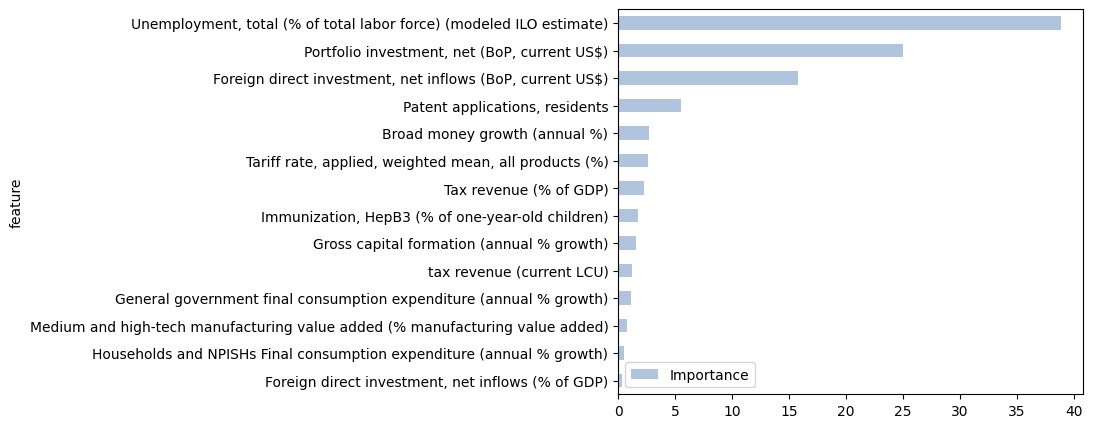

In [205]:
Importance = pd.DataFrame({'Importance':DTmortalityreg_bag.feature_importances_*100}, \
                          index=vif_data_1.feature)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='lightsteelblue', ) # kind='barh' : Horizontal bar
plt.gcf().set_size_inches(6, 5)

### Partial Dependency Plots

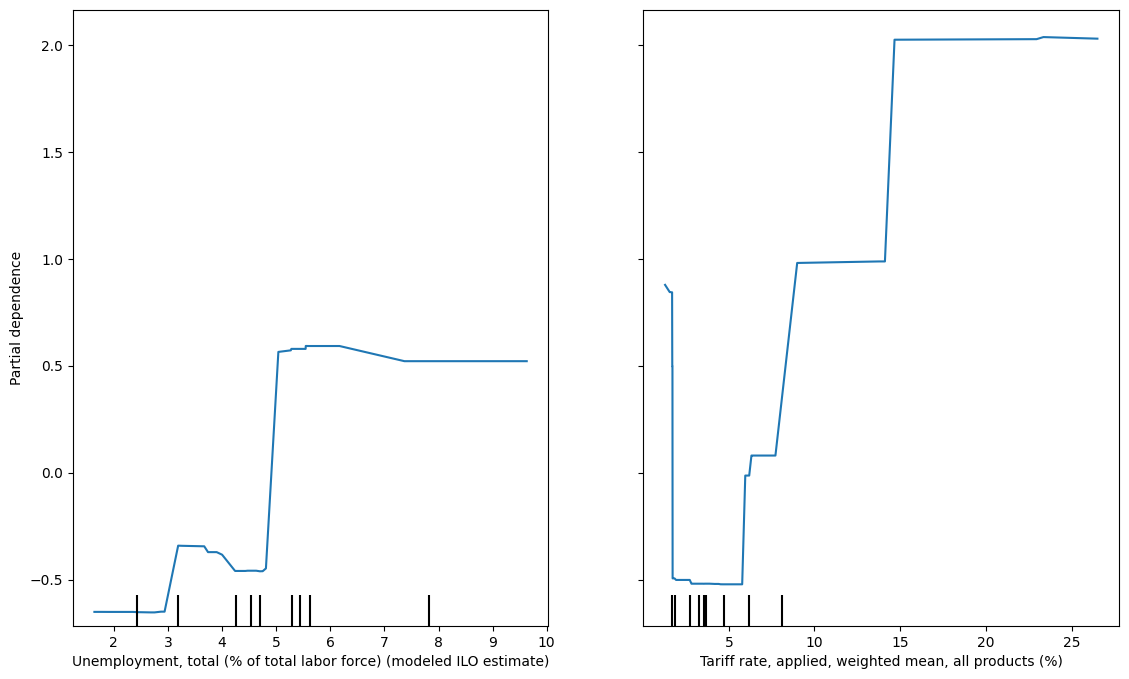

In [206]:
#Plotted the variables having most important as seen in the SHAP plot below
from sklearn.inspection import PartialDependenceDisplay
features = [3,2]
fig, ax = plt.subplots(figsize=(13.5, 8))
PartialDependenceDisplay.from_estimator(DTmortalityreg_boost, X_train, features, ax=ax)

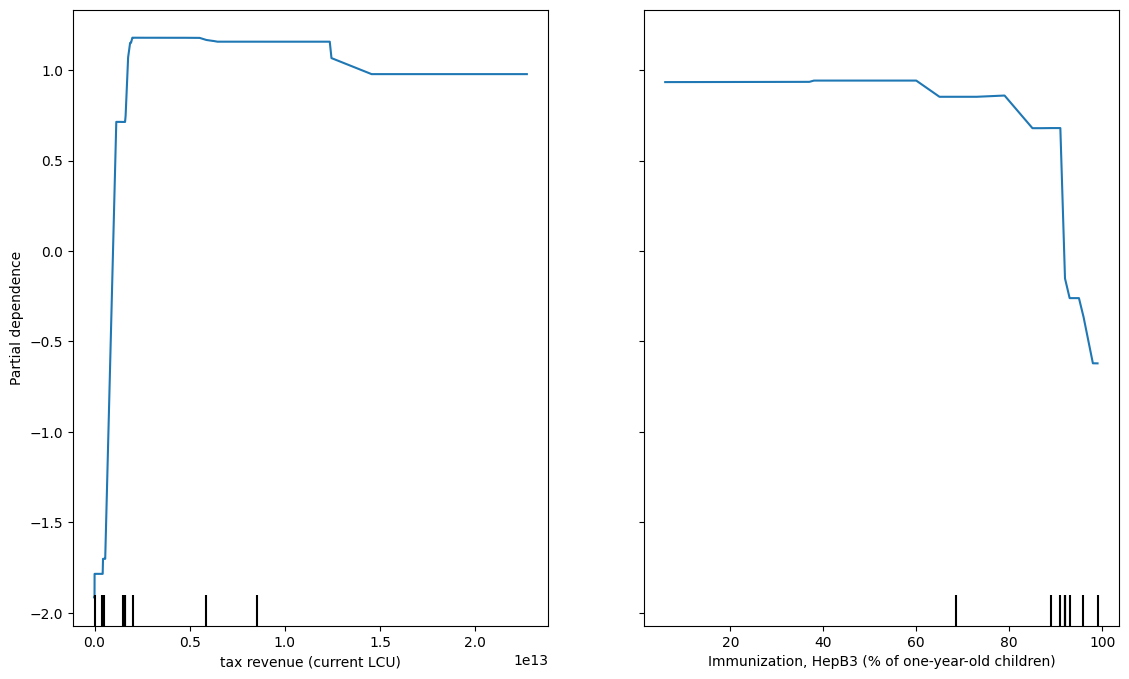

In [207]:
from sklearn.inspection import PartialDependenceDisplay
features = [0,8] # 3-unemployment,1-foreign,5-patent,11-portfolio
fig, ax = plt.subplots(figsize=(13.5, 8))  # Adjust width (10) and height (6) as needed
PartialDependenceDisplay.from_estimator(DTmortalityreg_boost, X_train, features, ax=ax)

### SHAP Explainer

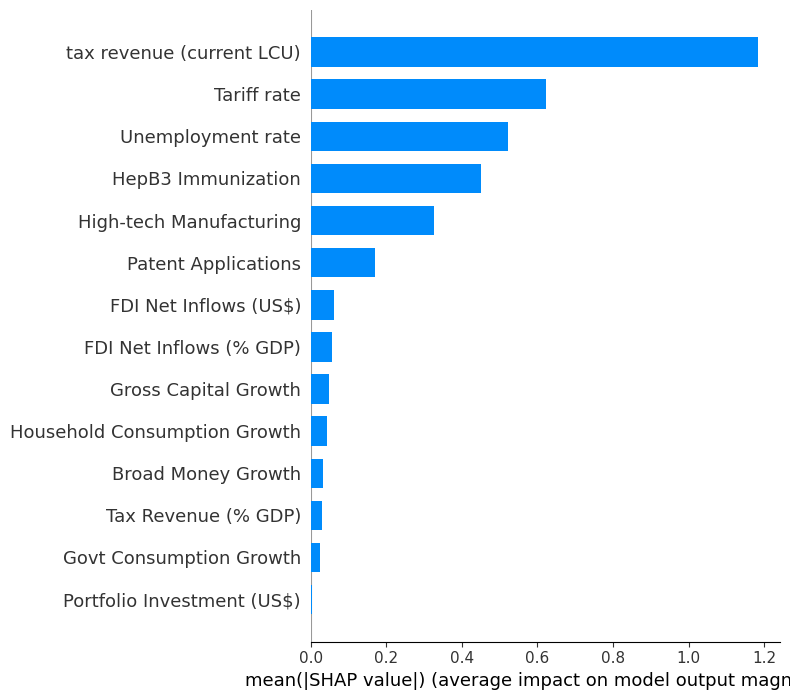

In [208]:
X_train_shortened = X_train.rename(columns={
    "Tariff rate, applied, weighted mean, all products (%)": "Tariff rate",
    "Unemployment, total (% of total labor force) (modeled ILO estimate)": "Unemployment rate",
    "Immunization, HepB3 (% of one-year-old children)": "HepB3 Immunization",
    "Medium and high-tech manufacturing value added (% manufacturing value added)": "High-tech Manufacturing",
    "Patent applications, residents": "Patent Applications",
    "Foreign direct investment, net inflows (BoP, current US$)": "FDI Net Inflows (US$)",
    "Foreign direct investment, net inflows (% of GDP)": "FDI Net Inflows (% GDP)",
    "Gross capital formation (annual % growth)": "Gross Capital Growth",
    "Households and NPISHs Final consumption expenditure (annual % growth)": "Household Consumption Growth",
    "Broad money growth (annual %)": "Broad Money Growth",
    "Tax revenue (% of GDP)": "Tax Revenue (% GDP)",
    "General government final consumption expenditure (annual % growth)": "Govt Consumption Growth",
    "Portfolio investment, net (BoP, current US$)": "Portfolio Investment (US$)",
    "Tax revenue (current LCU)": "Tax Revenue (LCU)"
})

explainer = shap.TreeExplainer(DTmortalityreg_boost)
shap_values=explainer.shap_values(X_train_shortened)
expected_value = explainer.expected_value
shap_values.shape
# Generate the SHAP summary plot with shortened names
shap.summary_plot(shap_values, X_train_shortened, plot_type="bar")



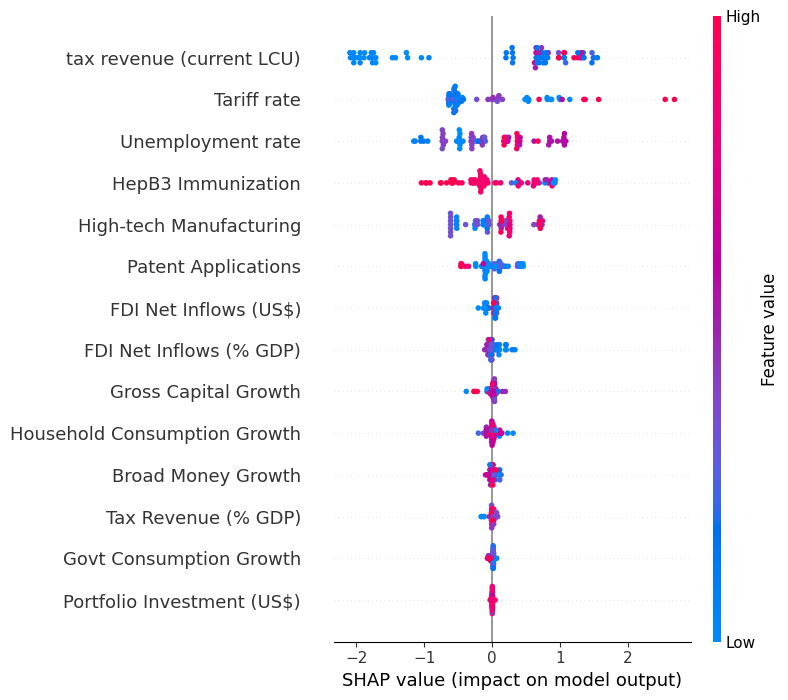

In [209]:
shap.summary_plot(shap_values, X_train_shortened, max_display=30)

In [210]:
#Checking value for India for 2010
india_data_2010 = visual_df[(visual_df['Country Name'] == 'India') & (visual_df['Year'] == 2010)]
india_data_2020 = visual_df[(visual_df['Country Name'] == 'India') & (visual_df['Year'] == 2020)]
india_data_2020

shap.initjs()
#features_used_in_model = X3.drop(columns=['Country Name'])
features_used_in_model = X_train_shortened.columns
shap.force_plot(explainer.expected_value, shap_values[31,:], features_used_in_model)


In [211]:
#Checking value for India for 2020
shap.initjs()
features_used_in_model = X_train_shortened.columns
shap.force_plot(explainer.expected_value, shap_values[41,:], features_used_in_model)

In [212]:
#Checking value for China for 2010
china_data_2010 = visual_df[(visual_df['Country Name'] == 'China') & (visual_df['Year'] == 2010)]
china_data_2020 = visual_df[(visual_df['Country Name'] == 'China') & (visual_df['Year'] == 2020)]
china_data_2010
china_data_2020


shap.initjs()
features_used_in_model = X_train.columns
shap.force_plot(explainer.expected_value, shap_values[10,:], features_used_in_model)

In [213]:
#Checking value for India for 2020
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[20,:], features_used_in_model)

In [214]:
#Checking value for UAE for 2010
uae_data_2010 = visual_df[(visual_df['Country Name'] == 'United Arab Emirates') & (visual_df['Year'] == 2010)]
uae_data_2020 = visual_df[(visual_df['Country Name'] == 'United Arab Emirates') & (visual_df['Year'] == 2020)]
uae_data_2010
uae_data_2020

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[52,:], features_used_in_model)

In [215]:
#Checking value for UAE for 2020
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[62,:], features_used_in_model)

## Visualizations

In [216]:
sdg.fillna(sdg.mode().iloc[0], inplace=True)

# Filter and rename columns for suicide rate data
suicide_rate = sdg[(sdg['Series Name'] == 'Suicide mortality rate (per 100,000 population)') & (sdg['Country Name'] == 'India')]
suicide_rate = suicide_rate.rename(columns={'Value': 'suicide_rate'})

# Filter and rename columns for unemployment rate data
unemployment_rate = sdg[(sdg['Series Name'] == 'Unemployment, total (% of total labor force) (modeled ILO estimate)') & (sdg['Country Name'] == 'India')]
unemployment_rate = unemployment_rate.rename(columns={'Value': 'unemployment_rate'})

# Assuming 'tariff_rate' data is available in sdg, filter and rename
tariff_rate = sdg[(sdg['Series Name'] == 'Tariff rate, applied, weighted mean, all products (%)') & (sdg['Country Name'] == 'India')]
tariff_rate = tariff_rate.rename(columns={'Value': 'tariff_rate'})

# Merge data on 'Year' (chain merges since we're merging three DataFrames)
df_merged = pd.merge(unemployment_rate[['Year', 'unemployment_rate']],
                     tariff_rate[['Year', 'tariff_rate']], on='Year')

df_merged = pd.merge(df_merged, suicide_rate[['Year', 'suicide_rate']], on='Year')

# Create a line plot
fig = px.line(df_merged, x='Year', y=['unemployment_rate', 'suicide_rate'],
              title='Unemployment vs Suicide Rate for India (2000-2018)')

fig.update_layout(
    xaxis_title='Year',
    yaxis=dict(title='Unemployment Rate'),
    yaxis2=dict(
        title='Suicide Rate',
        overlaying='y',
        side='right',
        anchor='free',
        position=0.85
    )
)

# Specify which data goes to which y-axis
fig.data[0].update(yaxis='y')
fig.data[1].update(yaxis='y2')

# Show the plot
fig.show()


In the above graph, we could see that once unemployement decreases the suicide rate plummets. It can be inferred from the plot that in the year 2008 when economic crises started globally the unemployment rate increased in India which eventually led to rise in suicides in India

In [217]:
sdg.fillna(sdg.mode().iloc[0], inplace=True)

# Filter the 'tariff_rate' for China
tariff_rate = sdg[(sdg['Series Name'] == 'Tariff rate, applied, weighted mean, all products (%)') & (sdg['Country Name'] == 'China')]
tariff_rate = tariff_rate.rename(columns={'Value': 'tariff_rate'})

# Filter the 'suicide_rate' for China
suicide_rate = sdg[(sdg['Series Name'] == 'Suicide mortality rate (per 100,000 population)') & (sdg['Country Name'] == 'China')]
suicide_rate = suicide_rate.rename(columns={'Value': 'suicide_rate'})

# Merge data on 'Year' (since we are now only using 'tariff_rate' and 'suicide_rate')
df_merged = pd.merge(tariff_rate[['Year', 'tariff_rate']],
                     suicide_rate[['Year', 'suicide_rate']], on='Year')

# Create a line plot
fig = px.line(df_merged, x='Year', y=['tariff_rate', 'suicide_rate'],
              title='Tariff Rate vs Suicide Rate for China (2000-2018)')

# Update the layout for dual y-axes
fig.update_layout(
    xaxis_title='Year',
    yaxis=dict(title='Tariff Rate'),
    yaxis2=dict(
        title='Suicide Rate',
        overlaying='y',  # Overlaying on the primary y-axis
        side='right'     # Positioning it on the right
    )
)

# Assign each trace to its respective y-axis
fig.data[0].update(yaxis='y')  # tariff_rate on y1
fig.data[1].update(yaxis='y2')  # suicide_rate on y2

# Show the plot
fig.show()


It can be inferred from the plot that tariff rate is positively correlated to the suicide rates in China. Over the years as the tariff rates has dropped in China, the suicide rates has significantly dropped.

In [218]:
sdg.fillna(sdg.mode(), inplace=True)
sucide_rate = sdg[(sdg['Series Name'] == 'Suicide mortality rate (per 100,000 population)') & (sdg['Country Name'] == 'United Kingdom')]
sucide_rate = sucide_rate.rename(columns={'Value': 'sucide_rate'})

unemployment_rate = sdg[(sdg['Series Name'] == 'Unemployment, total (% of total labor force) (modeled ILO estimate)') & (sdg['Country Name'] == 'United Kingdom')]
unemployment_rate = unemployment_rate.rename(columns={'Value': 'unemployment_rate'})

# Merge data on 'Year' (chain merges since we're merging three DataFrames)
df_merged = pd.merge(unemployment_rate[['Year', 'unemployment_rate']],
                     tariff_rate[['Year', 'tariff_rate']], on='Year')

df_merged = pd.merge(df_merged, sucide_rate[['Year', 'sucide_rate']], on='Year')

# Create a line plot
fig = px.line(df_merged, x='Year', y=['unemployment_rate', 'sucide_rate'],
              title='Umemployment vs Suicide Rate for United Kingdom (2000-2018)')

fig.update_layout(
    xaxis_title='Year',
    yaxis=dict(title='Unemployment Rate'),
    yaxis2=dict(
        title='Suicide Rate',
        overlaying='y',
        side='right',
        anchor='free',
        position=0.85
    )
)

fig.data[0].update(yaxis='y')
fig.data[1].update(yaxis='y2')

# Show the plot
fig.show()


In the above graph, we could see that once unemployement decreases the suicide rate plummets. It can be inferred from the plot that in the year 2008 when economic crises started globally the unemployment rate increased in UK which eventually led to rise in suicides in UK

In [219]:
sdg.fillna(sdg.mode(), inplace=True)
tariff_rate = sdg[(sdg['Series Name'] == 'Tariff rate, applied, weighted mean, all products (%)') & (sdg['Country Name'] == 'United Arab Emirates')]
tariff_rate = tariff_rate.rename(columns={'Value': 'tariff_rate'})

sucide_rate = sdg[(sdg['Series Name'] == 'Suicide mortality rate (per 100,000 population)') & (sdg['Country Name'] == 'United Arab Emirates')]
sucide_rate = sucide_rate.rename(columns={'Value': 'sucide_rate'})

unemployment_rate = sdg[(sdg['Series Name'] == 'Unemployment, total (% of total labor force) (modeled ILO estimate)') & (sdg['Country Name'] == 'United Arab Emirates')]
unemployment_rate = unemployment_rate.rename(columns={'Value': 'unemployment_rate'})

df_merged = pd.merge(unemployment_rate[['Year', 'unemployment_rate']],
                     tariff_rate[['Year', 'tariff_rate']], on='Year')

df_merged = pd.merge(df_merged, sucide_rate[['Year', 'sucide_rate']], on='Year')

fig = px.line(df_merged, x='Year', y=['unemployment_rate','sucide_rate', 'tariff_rate'],
              title='Umeployment and Tariff Rate effect on Suicide Rate for UAE (2000-2017)')

fig.update_layout(
    xaxis_title='Year',
    yaxis=dict(title='Unemployment Rate'),
    yaxis2=dict(
        title='Suicide Rate',
        overlaying='y',
        side='right',
        anchor='free',
        position=0.85
    ),
    yaxis3=dict(
        title='Tariff Rate',
        overlaying='y',
        side='right'
    )
)

fig.data[0].update(yaxis='y')
fig.data[1].update(yaxis='y2')
fig.data[2].update(yaxis='y3')

# Show the plot
fig.show()


In the above graph, it is visible that there is a rise in Suicide rates in UAE in year 2017, this is predominantly due to the ongoing crises in the middle-east which was accompanied by a huge fall in the prices of crude oil, which led to a recession in countries in Middle east including UAE. This further resulted in higher unemployement.

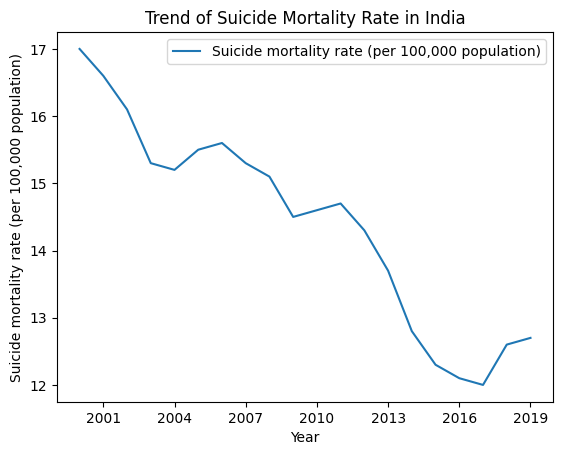

In [220]:
#Trend of Suicide Mortality Rate in India
india_data = visual_df[visual_df['Country Name'] == 'India']
sns.lineplot(data=india_data, x='Year', y='Suicide mortality rate (per 100,000 population)', label="Suicide mortality rate (per 100,000 population)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Trend of Suicide Mortality Rate in India")
plt.show()


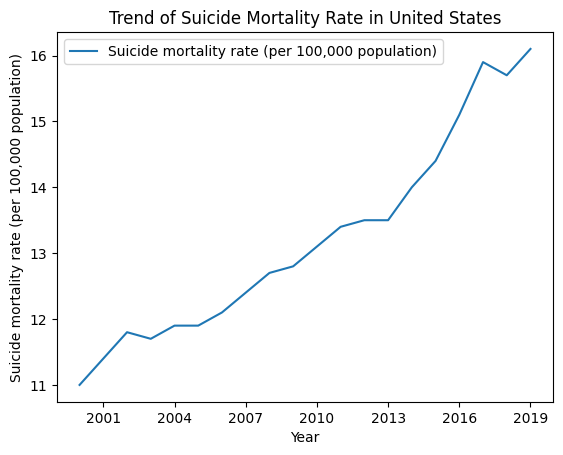

In [221]:
#Trend of Suicide Mortality Rate in United States
usa_data = visual_df[visual_df['Country Name'] == 'United States']
sns.lineplot(data=usa_data, x='Year', y='Suicide mortality rate (per 100,000 population)', label="Suicide mortality rate (per 100,000 population)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Trend of Suicide Mortality Rate in United States")
plt.show()

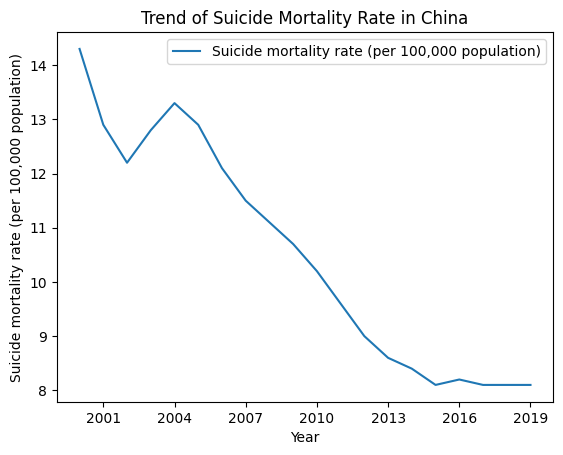

In [222]:
#Trend of Suicide Mortality Rate in China
china_data = visual_df[visual_df['Country Name'] == 'China']
sns.lineplot(data=china_data, x='Year', y='Suicide mortality rate (per 100,000 population)', label="Suicide mortality rate (per 100,000 population)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Trend of Suicide Mortality Rate in China")
plt.show()

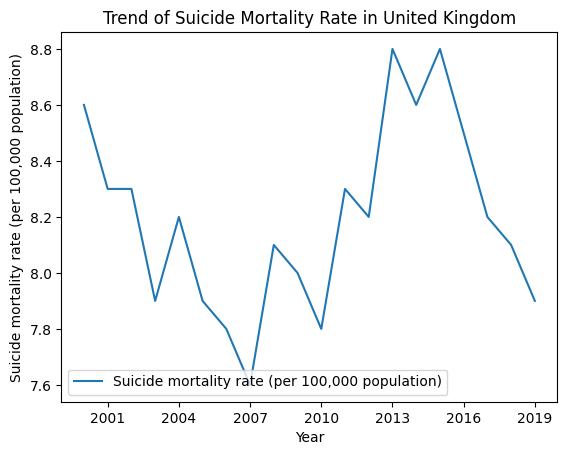

In [223]:
#Trend of Suicide Mortality Rate in United Kingdom
uk_data = visual_df[visual_df['Country Name'] == 'United Kingdom']
sns.lineplot(data=uk_data, x='Year', y='Suicide mortality rate (per 100,000 population)', label="Suicide mortality rate (per 100,000 population)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Trend of Suicide Mortality Rate in United Kingdom")
plt.show()

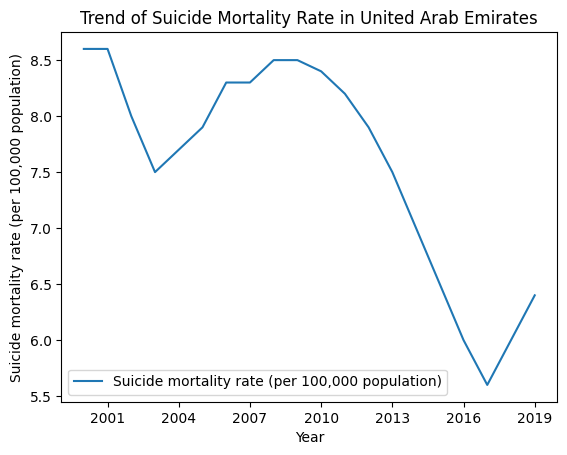

In [224]:
#Trend of Suicide Mortality Rate in United Arab Emirates
uae_data = visual_df[visual_df['Country Name'] == 'United Arab Emirates']
sns.lineplot(data=uae_data, x='Year', y='Suicide mortality rate (per 100,000 population)', label="Suicide mortality rate (per 100,000 population)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Trend of Suicide Mortality Rate in United Arab Emirates")
plt.show()

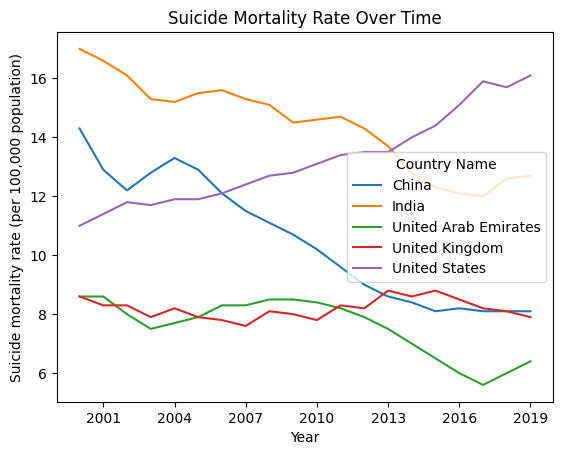

In [225]:
#Suicide Mortality Rate Over Time
countries = ['India', 'United Kingdom', 'United States', 'China', 'United Arab Emirates']
filtered_data = visual_df[visual_df['Country Name'].isin(countries)]
sns.lineplot(data=filtered_data, x='Year', y='Suicide mortality rate (per 100,000 population)', hue='Country Name')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Suicide Mortality Rate Over Time")
plt.show()


In [226]:
import plotly.graph_objects as go
# This could show the distribution of a specific feature for different categories
fig = px.box(visual_df, x="Country Name", y="Suicide mortality rate (per 100,000 population)", color="Country Name", title="Box Plot for Suicide Mortality Rate Over Time across all selected countries")
fig.show()